In [1]:
import os
from utils import f1_score_function
from BertClassifier import BertClassifier, init_bert_clf, train_bert_clf, eval_bert_clf
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
import torch
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-10 23:17:26.171712: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Analyze dataset

In [2]:
texts_df = pd.read_csv('subtaskA_train.csv')

In [3]:
texts_df.head()

,Id,comment_text,conspiratorial
0,0,⚡Se non ci fossero soldati non ci sarebbero gu...,0
1,1,"21/08/21]( [PRE-PRINT]\n\n📄__ ""Shedding of Inf...",1
2,2,PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA V...,1
3,3,L'Aspirina non aumenta la sopravvivenza dei pa...,0
4,4,L'Italia non puo' dare armi lo vieta la Costit...,0


In [4]:
texts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1842 entries, 0 to 1841
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              1842 non-null   int64 
 1   comment_text    1842 non-null   object
 2   conspiratorial  1842 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 43.3+ KB


In [5]:
texts_df[texts_df['comment_text'].isna()]

,Id,comment_text,conspiratorial


In [6]:
texts_df = texts_df[texts_df.comment_text.notna()]

In [7]:
texts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1842 entries, 0 to 1841
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              1842 non-null   int64 
 1   comment_text    1842 non-null   object
 2   conspiratorial  1842 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 57.6+ KB


In [8]:
texts_df.conspiratorial.value_counts()

1    925
0    917
Name: conspiratorial, dtype: int64

## Preprocessing

Remove break line characthers

In [9]:
texts_df.comment_text = texts_df.comment_text.apply(lambda text: text.replace('\n\n', ' ').replace('\n', ' '))

## Train-Validation split

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

80-20 train-validation split

In [11]:
# Split the data into training and testing datasets using stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, eval_index in split.split(texts_df, texts_df.conspiratorial):
    train_df, val_df = texts_df.iloc[train_index], texts_df.iloc[eval_index]

In [12]:
print(train_df.info())
print(train_df.conspiratorial.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1473 entries, 1509 to 1768
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              1473 non-null   int64 
 1   comment_text    1473 non-null   object
 2   conspiratorial  1473 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 46.0+ KB
None
1    740
0    733
Name: conspiratorial, dtype: int64


In [13]:
print(val_df.info())
print(val_df.conspiratorial.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369 entries, 361 to 667
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              369 non-null    int64 
 1   comment_text    369 non-null    object
 2   conspiratorial  369 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 11.5+ KB
None
1    185
0    184
Name: conspiratorial, dtype: int64


## Tokenization

In [14]:
from transformers import BertTokenizer

In [15]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-italian-xxl-cased', do_lower_case=False)

texts_tr = train_df['comment_text']
labels_tr = train_df['conspiratorial'].to_numpy()

In [16]:
texts_tr = train_df['comment_text']
labels_tr = train_df['conspiratorial'].to_numpy()

texts_val = val_df['comment_text']
labels_val = val_df['conspiratorial'].to_numpy()

Observe distribution of tokenized texts lengths by trying a simple tokenization on both tr and val sets.

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


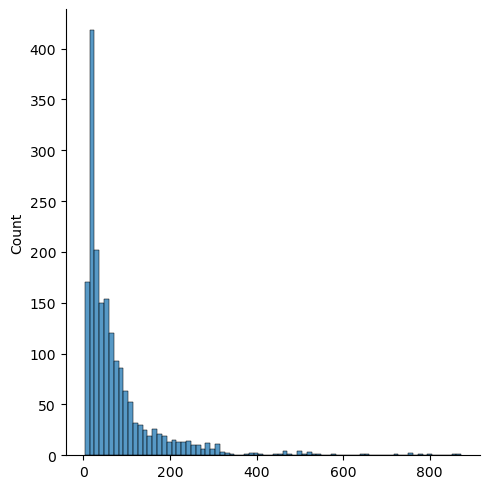

In [17]:
tokenized_len_list = []

for sentence in texts_tr:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))
for sentence in texts_val:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))

sns.displot(tokenized_len_list)
plt.show()

The maximum tokenized length is above the BERT max_lenght limit of 512. Very few texts are above this limit, so we truncate to 512

In [18]:
# Tokenize all of the sentences and map the tokens to thier word IDs.

# Tr set
input_ids_tr = []
attention_masks_tr = []

# `encode_plus` will:
#   1. Tokenize the sentence, 2. Prepend the `[CLS]` token to the start, 3. Append the `[SEP]` token to the end
#   4. Map tokens to their IDs, 5. Pad or truncate the sentence to `max_length`, 6. Create attention masks for [PAD] tokens

for sentence in texts_tr:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence and attention mask to the list.    
    input_ids_tr.append(encoded_dict['input_ids'])
    attention_masks_tr.append(encoded_dict['attention_mask'])

# Val set
input_ids_val = []
attention_masks_val = []

for sentence in texts_val:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence and attention mask to the list.    
    input_ids_val.append(encoded_dict['input_ids'])
    attention_masks_val.append(encoded_dict['attention_mask'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
# Convert the lists into tensors

input_ids_tr = torch.cat(input_ids_tr, dim=0)
input_ids_val = torch.cat(input_ids_val, dim=0)

attention_masks_tr = torch.cat(attention_masks_tr, dim=0)
attention_masks_val = torch.cat(attention_masks_val, dim=0)

labels_tr = torch.tensor(labels_tr)
labels_val = torch.tensor(labels_val)

## Generate DataLoaders

In [20]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

Wrap data into a TensorDataset

In [21]:
tr_dataset = TensorDataset(input_ids_tr, attention_masks_tr, labels_tr)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)

The DataLoader needs to know our batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

In [22]:
batch_size = 16

Create the DataLoaders for our training and validation sets. Tr samples are taken in random order, while validation are taken sequentially.

In [23]:
tr_dataloader = DataLoader(tr_dataset, sampler=RandomSampler(tr_dataset), batch_size = batch_size)

val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size = batch_size)

## Training Grid Search

In [24]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

Set save folder for this run

In [25]:
from datetime import datetime
curr_date = datetime.now()

print(datetime.now())

save_folder_pth = './bert_subtaskA/{}_{}_{}-{}.{}'.format(curr_date.day, curr_date.month, curr_date.day, curr_date.hour, curr_date.minute)
if not os.path.exists(save_folder_pth):
    os.makedirs(save_folder_pth)

2023-04-10 23:17:42.950516


Fixed general hyperparams

In [26]:
max_epochs = 12


# Num batches*num epochs
tr_steps = len(tr_dataloader)*max_epochs

Variable grid searched hyperparams

In [29]:
lr_list = [0.5e-5, 0.2e-5, 0.8e-5]
warmup_perc_list = [0.1, 0.05] # Percentage of warmup steps for scheduler on the total tr steps
clf_head_list = []

head1 = nn.Sequential(
                nn.Linear(768, 128),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(128, 2),
                )
clf_head_list.append((head1, '2_layers_S')) # Each head obeject is composed by a tuple (head, name)

head2 = nn.Sequential(
                nn.Linear(768, 256),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(256, 2),
                )
clf_head_list.append((head2, '2_layers_M'))

head3 = nn.Sequential(
                nn.Linear(768, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 32),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(32, 2),
                )
clf_head_list.append((head3, '3_layers_M'))

Initialize, train/eval and save function for each grid search run

In [28]:
def train_eval_model(lr, warmup_steps, head, model_folder_pth):

    torch.cuda.empty_cache()
    #print(torch.cuda.memory_summary())

    # Initialize model
    bert_clf_model, loss_function, optimizer, scheduler, device = init_bert_clf(tr_steps=tr_steps, lr_rate=lr, scheduler_warmp_steps=warmup_steps, head=head)

    for epoch_i in range(max_epochs):
        print('Epoch: {}'.format(epoch_i))

        # Train
        avg_epoch_loss_tr, acc_score_tr, f1_score_tr, bert_clf_model, optimizer, scheduler = train_bert_clf(bert_clf_model, tr_dataloader, loss_function, optimizer, scheduler, device)


        print('TRAINING | Tr Loss: {} - Tr acc: {} - Tr f1: {}'.format(avg_epoch_loss_tr, acc_score_tr, f1_score_tr))

        # Eval
        avg_epoch_loss_val, acc_score_val, f1_score_val, predictions, labels = eval_bert_clf(bert_clf_model, val_dataloader, loss_function, device)
        print('EVALUATION | Val Loss: {} - Val acc: {} - Val f1: {}'.format(avg_epoch_loss_val, acc_score_val, f1_score_val))

        # Save
        model_save_pth = os.path.join(model_folder_pth, 'bert_clf_{}.pt'.format(epoch_i))
        torch.save({
                    'epoch': epoch_i,
                    'model_state_dict': bert_clf_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'schdeduler_state_dict': scheduler.state_dict(),
                    'tr_loss': avg_epoch_loss_tr,
                    'val_loss': avg_epoch_loss_val,
                    'tr_acc': acc_score_tr,
                    'val_acc': acc_score_val,
                    'tr_f1': f1_score_tr,
                    'val_f1': f1_score_val,
                    'val_preds': predictions
                    }, model_save_pth)

    torch.cuda.empty_cache()


Grid Search loop

In [29]:
num_trials = len(lr_list) * len(warmup_perc_list) * len(clf_head_list)
print('Executing {} trials in grid search'.format(num_trials))


for lr in lr_list:
    for clf_head_tuple in clf_head_list:
        for warmup_perc in warmup_perc_list:
            
            # Model save path subfolder
            model_folder_str = 'lr{}_warmup{}_head_{}'.format(lr, warmup_perc, clf_head_tuple[1])
            model_folder_pth = os.path.join(save_folder_pth, model_folder_str)
            if not os.path.exists(model_folder_pth):
                os.makedirs(model_folder_pth)

            print()
            print('Executing model with lr={}, warmup perc.={}, head={}'.format(lr, warmup_perc, clf_head_tuple[1]))

            train_eval_model(lr, warmup_steps=warmup_perc*tr_steps, head=clf_head_tuple[0], model_folder_pth=model_folder_pth)

           

Executing 18 trials in grid search

Executing model with lr=5e-06, warmup perc.=0.1, head=2_layers_S


Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6524170137220814 - Tr acc: 0.6252545824847251 - Tr f1: 0.6243818970678453
EVALUATION | Val Loss: 0.589568509409825 - Val acc: 0.7371273712737128 - Val f1: 0.7309302762638602
Epoch: 1
TRAINING | Tr Loss: 0.5228733808122655 - Tr acc: 0.7359131025118805 - Tr f1: 0.7352449089824526
EVALUATION | Val Loss: 0.5198769209285578 - Val acc: 0.7452574525745257 - Val f1: 0.7370998059665292
Epoch: 2
TRAINING | Tr Loss: 0.39583702773977353 - Tr acc: 0.8262050237610319 - Tr f1: 0.8260702715069039
EVALUATION | Val Loss: 0.42488194939990837 - Val acc: 0.8048780487804879 - Val f1: 0.8047044986768598
Epoch: 3
TRAINING | Tr Loss: 0.2746654768945068 - Tr acc: 0.8845892735913102 - Tr f1: 0.8845658114551871
EVALUATION | Val Loss: 0.4605340287089348 - Val acc: 0.8075880758807588 - Val f1: 0.8074975936280742
Epoch: 4
TRAINING | Tr Loss: 0.1825512855924586 - Tr acc: 0.9314324507807196 - Tr f1: 0.931371

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6225509755713965 - Tr acc: 0.6558044806517311 - Tr f1: 0.6557987696876931
EVALUATION | Val Loss: 0.5721817420174679 - Val acc: 0.7479674796747967 - Val f1: 0.742451874366768
Epoch: 1
TRAINING | Tr Loss: 0.4508457632475002 - Tr acc: 0.7841140529531568 - Tr f1: 0.7839920977780073
EVALUATION | Val Loss: 0.4390645883977413 - Val acc: 0.7886178861788617 - Val f1: 0.7883551973645508
Epoch: 2
TRAINING | Tr Loss: 0.3231807146021115 - Tr acc: 0.8689748811948405 - Tr f1: 0.8688965718562669
EVALUATION | Val Loss: 0.4529795361061891 - Val acc: 0.7940379403794038 - Val f1: 0.7929292929292928
Epoch: 3
TRAINING | Tr Loss: 0.20322386904429363 - Tr acc: 0.9239646978954514 - Tr f1: 0.9239492404881233
EVALUATION | Val Loss: 0.5829295413568616 - Val acc: 0.7723577235772358 - Val f1: 0.7671854344429756
Epoch: 4
TRAINING | Tr Loss: 0.13250357630131868 - Tr acc: 0.9545145960624576 - Tr f1: 0.954511

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6664414566050294 - Tr acc: 0.6191446028513238 - Tr f1: 0.6177174714069806
EVALUATION | Val Loss: 0.6023707414666811 - Val acc: 0.6883468834688347 - Val f1: 0.6876035248128272
Epoch: 1
TRAINING | Tr Loss: 0.5756658017635345 - Tr acc: 0.7169042769857433 - Tr f1: 0.715843468051178
EVALUATION | Val Loss: 0.5141953801115354 - Val acc: 0.7669376693766937 - Val f1: 0.7643048128342246
Epoch: 2
TRAINING | Tr Loss: 0.4436830213313462 - Tr acc: 0.7868295994568907 - Tr f1: 0.7861173898406661
EVALUATION | Val Loss: 0.46506956902643043 - Val acc: 0.7913279132791328 - Val f1: 0.7912727272727273
Epoch: 3
TRAINING | Tr Loss: 0.30536370019438447 - Tr acc: 0.8778004073319755 - Tr f1: 0.8777056596532917
EVALUATION | Val Loss: 0.5591097449262937 - Val acc: 0.7859078590785907 - Val f1: 0.7836130555163787
Epoch: 4
TRAINING | Tr Loss: 0.22826415179197185 - Tr acc: 0.9110658520027155 - Tr f1: 0.91100

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6123975444865483 - Tr acc: 0.648336727766463 - Tr f1: 0.6441909526367625
EVALUATION | Val Loss: 0.5458757728338242 - Val acc: 0.7208672086720868 - Val f1: 0.7196813806837039
Epoch: 1
TRAINING | Tr Loss: 0.4701941285722999 - Tr acc: 0.7834351663272233 - Tr f1: 0.7827944801738432
EVALUATION | Val Loss: 0.4790584898243348 - Val acc: 0.7750677506775068 - Val f1: 0.7721154490055582
Epoch: 2
TRAINING | Tr Loss: 0.3420136534078147 - Tr acc: 0.8479293957909029 - Tr f1: 0.8478620119809956
EVALUATION | Val Loss: 0.44895600403348607 - Val acc: 0.8157181571815718 - Val f1: 0.8156843156843158
Epoch: 3
TRAINING | Tr Loss: 0.2406460968076542 - Tr acc: 0.9083503054989817 - Tr f1: 0.9083366176440084
EVALUATION | Val Loss: 0.46736821842690307 - Val acc: 0.8130081300813008 - Val f1: 0.8129201966244664
Epoch: 4
TRAINING | Tr Loss: 0.14610381174071502 - Tr acc: 0.9490835030549898 - Tr f1: 0.94908

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6770906057409061 - Tr acc: 0.5852002715546504 - Tr f1: 0.5847593342330185
EVALUATION | Val Loss: 0.6371713876724243 - Val acc: 0.6747967479674797 - Val f1: 0.6707317073170732
Epoch: 1
TRAINING | Tr Loss: 0.6126449681738372 - Tr acc: 0.6945010183299389 - Tr f1: 0.69418967299033
EVALUATION | Val Loss: 0.5379773713648319 - Val acc: 0.7235772357723578 - Val f1: 0.7234126984126983
Epoch: 2
TRAINING | Tr Loss: 0.4881986515816822 - Tr acc: 0.7793618465716226 - Tr f1: 0.7792149094791507
EVALUATION | Val Loss: 0.4856514787922303 - Val acc: 0.7669376693766937 - Val f1: 0.7669222633527233
Epoch: 3
TRAINING | Tr Loss: 0.38882865924989024 - Tr acc: 0.8438560760353021 - Tr f1: 0.8436380788515644
EVALUATION | Val Loss: 0.5174163486808538 - Val acc: 0.7696476964769647 - Val f1: 0.7638124355218868
Epoch: 4
TRAINING | Tr Loss: 0.2870794328790839 - Tr acc: 0.902919212491514 - Tr f1: 0.902888956

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6250790053157396 - Tr acc: 0.6463000678886626 - Tr f1: 0.6448537711029652
EVALUATION | Val Loss: 0.5220527897278467 - Val acc: 0.7533875338753387 - Val f1: 0.751746623195156
Epoch: 1
TRAINING | Tr Loss: 0.45624843095579454 - Tr acc: 0.7949762389680923 - Tr f1: 0.7943232046753343
EVALUATION | Val Loss: 0.4676088181634744 - Val acc: 0.7723577235772358 - Val f1: 0.7707396449704143
Epoch: 2
TRAINING | Tr Loss: 0.3298138973693694 - Tr acc: 0.8642226748133062 - Tr f1: 0.8642045873589498
EVALUATION | Val Loss: 0.43040941283106804 - Val acc: 0.8021680216802168 - Val f1: 0.8021680216802168
Epoch: 3
TRAINING | Tr Loss: 0.21164260592351677 - Tr acc: 0.9327902240325866 - Tr f1: 0.9327692776525055
EVALUATION | Val Loss: 0.5491756390159329 - Val acc: 0.7696476964769647 - Val f1: 0.7663252002235053
Epoch: 4
TRAINING | Tr Loss: 0.1333125174065591 - Tr acc: 0.9626612355736592 - Tr f1: 0.96266

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6350962173554205 - Tr acc: 0.6381534283774609 - Tr f1: 0.6380867079175174
EVALUATION | Val Loss: 0.570992591480414 - Val acc: 0.6991869918699187 - Val f1: 0.6962962962962962
Epoch: 1
TRAINING | Tr Loss: 0.5348738672271851 - Tr acc: 0.7386286490156144 - Tr f1: 0.7383508079864355
EVALUATION | Val Loss: 0.4960999383280675 - Val acc: 0.7560975609756098 - Val f1: 0.7553050397877985
Epoch: 2
TRAINING | Tr Loss: 0.441020661624529 - Tr acc: 0.7895451459606245 - Tr f1: 0.7892069606065419
EVALUATION | Val Loss: 0.4525105655193329 - Val acc: 0.8075880758807588 - Val f1: 0.8075371900826447
Epoch: 3
TRAINING | Tr Loss: 0.40396349949221455 - Tr acc: 0.8282416836388323 - Tr f1: 0.8281272987637696
EVALUATION | Val Loss: 0.4307134449481964 - Val acc: 0.8075880758807588 - Val f1: 0.8075880758807589
Epoch: 4
TRAINING | Tr Loss: 0.3319256812814743 - Tr acc: 0.8635437881873728 - Tr f1: 0.86351334

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6174701368936928 - Tr acc: 0.6327223353699932 - Tr f1: 0.6326789962354913
EVALUATION | Val Loss: 0.5240930318832397 - Val acc: 0.7317073170731707 - Val f1: 0.7314232779726064
Epoch: 1
TRAINING | Tr Loss: 0.483862883461419 - Tr acc: 0.7691785471826205 - Tr f1: 0.7688076342136265
EVALUATION | Val Loss: 0.4680971633642912 - Val acc: 0.7831978319783198 - Val f1: 0.7830049985298442
Epoch: 2
TRAINING | Tr Loss: 0.4101829990263908 - Tr acc: 0.8139850644942295 - Tr f1: 0.8138112952690958
EVALUATION | Val Loss: 0.4426740116129319 - Val acc: 0.7859078590785907 - Val f1: 0.7855045804054303
Epoch: 3
TRAINING | Tr Loss: 0.3319159976897701 - Tr acc: 0.8533604887983707 - Tr f1: 0.8533360868234435
EVALUATION | Val Loss: 0.4297253756473462 - Val acc: 0.7886178861788617 - Val f1: 0.7886039132734004
Epoch: 4
TRAINING | Tr Loss: 0.2937247848478697 - Tr acc: 0.878479293957909 - Tr f1: 0.878398365

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6499040242164366 - Tr acc: 0.6591989137813985 - Tr f1: 0.6575243617770203
EVALUATION | Val Loss: 0.64022546261549 - Val acc: 0.6585365853658537 - Val f1: 0.6429909699612999
Epoch: 1
TRAINING | Tr Loss: 0.5596604193410566 - Tr acc: 0.712152070604209 - Tr f1: 0.7102610541629862
EVALUATION | Val Loss: 0.5341508810718855 - Val acc: 0.7371273712737128 - Val f1: 0.7358157729637969
Epoch: 2
TRAINING | Tr Loss: 0.4717274311409202 - Tr acc: 0.7718940936863544 - Tr f1: 0.7713924639994679
EVALUATION | Val Loss: 0.492018040890495 - Val acc: 0.7886178861788617 - Val f1: 0.7886163337250294
Epoch: 3
TRAINING | Tr Loss: 0.4040044254513197 - Tr acc: 0.814663951120163 - Tr f1: 0.8142681301830628
EVALUATION | Val Loss: 0.48174678596357506 - Val acc: 0.7886178861788617 - Val f1: 0.7877934410758523
Epoch: 4
TRAINING | Tr Loss: 0.3616397187754672 - Tr acc: 0.8445349626612356 - Tr f1: 0.84444204639

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6049032498111007 - Tr acc: 0.6768499660556687 - Tr f1: 0.6751357562503475
EVALUATION | Val Loss: 0.5326146471003691 - Val acc: 0.7262872628726287 - Val f1: 0.7262792217807384
Epoch: 1
TRAINING | Tr Loss: 0.4901732903334402 - Tr acc: 0.7705363204344874 - Tr f1: 0.7696571927707723
EVALUATION | Val Loss: 0.49747039129336673 - Val acc: 0.7642276422764228 - Val f1: 0.7640543579717921
Epoch: 2
TRAINING | Tr Loss: 0.41557152937817315 - Tr acc: 0.8139850644942295 - Tr f1: 0.8139225449515906
EVALUATION | Val Loss: 0.492914463703831 - Val acc: 0.7859078590785907 - Val f1: 0.7848396501457726
Epoch: 3
TRAINING | Tr Loss: 0.36357999136371 - Tr acc: 0.8418194161575017 - Tr f1: 0.8417026846649809
EVALUATION | Val Loss: 0.47421249747276306 - Val acc: 0.7886178861788617 - Val f1: 0.7885417891148465
Epoch: 4
TRAINING | Tr Loss: 0.3075534807898665 - Tr acc: 0.8628649015614392 - Tr f1: 0.8627585

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.6306906916121001 - Tr acc: 0.6646300067888663 - Tr f1: 0.6577396182964825
EVALUATION | Val Loss: 0.573084923128287 - Val acc: 0.7046070460704607 - Val f1: 0.6960254540232925
Epoch: 1
TRAINING | Tr Loss: 0.5210103395805564 - Tr acc: 0.7488119484046164 - Tr f1: 0.7482269962230124
EVALUATION | Val Loss: 0.49269303182760876 - Val acc: 0.7642276422764228 - Val f1: 0.7642276422764227
Epoch: 2
TRAINING | Tr Loss: 0.43405105189610554 - Tr acc: 0.790224032586558 - Tr f1: 0.7899622754698261
EVALUATION | Val Loss: 0.4413057683656613 - Val acc: 0.7940379403794038 - Val f1: 0.7940364277320799
Epoch: 3
TRAINING | Tr Loss: 0.3873684729940148 - Tr acc: 0.8431771894093686 - Tr f1: 0.8430371350032038
EVALUATION | Val Loss: 0.4428507598737876 - Val acc: 0.8021680216802168 - Val f1: 0.8013275804845669
Epoch: 4
TRAINING | Tr Loss: 0.3352253281821807 - Tr acc: 0.856754921928038 - Tr f1: 0.85666930

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.5983756988920191 - Tr acc: 0.6680244399185336 - Tr f1: 0.6676414905854434
EVALUATION | Val Loss: 0.5204490249355634 - Val acc: 0.7533875338753387 - Val f1: 0.7491427418812613
Epoch: 1
TRAINING | Tr Loss: 0.47101821341822225 - Tr acc: 0.781398506449423 - Tr f1: 0.7809720046695827
EVALUATION | Val Loss: 0.4717090980460246 - Val acc: 0.7994579945799458 - Val f1: 0.7993857999294699
Epoch: 2
TRAINING | Tr Loss: 0.4143461013032544 - Tr acc: 0.811948404616429 - Tr f1: 0.8115227576866348
EVALUATION | Val Loss: 0.4739815201610327 - Val acc: 0.7913279132791328 - Val f1: 0.7901194442187374
Epoch: 3
TRAINING | Tr Loss: 0.3418298485458538 - Tr acc: 0.8499660556687033 - Tr f1: 0.8498763853898184
EVALUATION | Val Loss: 0.45418232679367065 - Val acc: 0.8157181571815718 - Val f1: 0.8152282768777614
Epoch: 4
TRAINING | Tr Loss: 0.3001510731535413 - Tr acc: 0.8710115410726409 - Tr f1: 0.8709681

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.5776188735679914 - Tr acc: 0.6904276985743381 - Tr f1: 0.6904275558964073
EVALUATION | Val Loss: 0.5061120055615902 - Val acc: 0.7533875338753387 - Val f1: 0.7498305084745762
Epoch: 1
TRAINING | Tr Loss: 0.39121658106644946 - Tr acc: 0.8160217243720299 - Tr f1: 0.8158574181206416
EVALUATION | Val Loss: 0.5762045442437133 - Val acc: 0.7506775067750677 - Val f1: 0.7416438356164383
Epoch: 2
TRAINING | Tr Loss: 0.22357572492722783 - Tr acc: 0.911744738628649 - Tr f1: 0.9117355856453825
EVALUATION | Val Loss: 0.5023024920374155 - Val acc: 0.8102981029810298 - Val f1: 0.8102855631940773
Epoch: 3
TRAINING | Tr Loss: 0.10609239861569418 - Tr acc: 0.9674134419551935 - Tr f1: 0.9674100623921411
EVALUATION | Val Loss: 0.7077249065041542 - Val acc: 0.8184281842818428 - Val f1: 0.8184281842818427
Epoch: 4
TRAINING | Tr Loss: 0.03826956380338919 - Tr acc: 0.988458927359131 - Tr f1: 0.98845

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.5565742750962576 - Tr acc: 0.7128309572301426 - Tr f1: 0.7128261924613299
EVALUATION | Val Loss: 0.4922483892490466 - Val acc: 0.7723577235772358 - Val f1: 0.7686036789297659
Epoch: 1
TRAINING | Tr Loss: 0.31592427506562204 - Tr acc: 0.8628649015614392 - Tr f1: 0.8628188105117566
EVALUATION | Val Loss: 0.49386512984832126 - Val acc: 0.7696476964769647 - Val f1: 0.7649804806042395
Epoch: 2
TRAINING | Tr Loss: 0.1554482248511606 - Tr acc: 0.9484046164290564 - Tr f1: 0.9483992654542237
EVALUATION | Val Loss: 0.6844281541804472 - Val acc: 0.7831978319783198 - Val f1: 0.7799248523886205
Epoch: 3
TRAINING | Tr Loss: 0.08068244779352299 - Tr acc: 0.9755600814663951 - Tr f1: 0.9755595295158733
EVALUATION | Val Loss: 0.9130552336573601 - Val acc: 0.7831978319783198 - Val f1: 0.7812296199679848
Epoch: 4
TRAINING | Tr Loss: 0.048584331407509646 - Tr acc: 0.9877800407331976 - Tr f1: 0.98

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.5786420731775223 - Tr acc: 0.6965376782077393 - Tr f1: 0.695349251480036
EVALUATION | Val Loss: 0.4781147725880146 - Val acc: 0.7588075880758808 - Val f1: 0.758232293116014
Epoch: 1
TRAINING | Tr Loss: 0.4151860321721723 - Tr acc: 0.7949762389680923 - Tr f1: 0.7948853911529495
EVALUATION | Val Loss: 0.4093067354212205 - Val acc: 0.7994579945799458 - Val f1: 0.7992796236401059
Epoch: 2
TRAINING | Tr Loss: 0.23724957984141123 - Tr acc: 0.9097080787508486 - Tr f1: 0.9096799386644772
EVALUATION | Val Loss: 0.5180203864971796 - Val acc: 0.7831978319783198 - Val f1: 0.782736693358455
Epoch: 3
TRAINING | Tr Loss: 0.09625576433515357 - Tr acc: 0.9653767820773931 - Tr f1: 0.9653751862645641
EVALUATION | Val Loss: 0.8202671996938685 - Val acc: 0.8265582655826558 - Val f1: 0.826189354686764
Epoch: 4
TRAINING | Tr Loss: 0.04105507041814597 - Tr acc: 0.9830278343516633 - Tr f1: 0.98302705

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.5402112484619181 - Tr acc: 0.7141887304820095 - Tr f1: 0.7135783253006205
EVALUATION | Val Loss: 0.4465000020960967 - Val acc: 0.7886178861788617 - Val f1: 0.7884920634920635
Epoch: 1
TRAINING | Tr Loss: 0.3142950616136033 - Tr acc: 0.8540393754243042 - Tr f1: 0.8539788060746144
EVALUATION | Val Loss: 0.44453726274271804 - Val acc: 0.8130081300813008 - Val f1: 0.8129861544676631
Epoch: 2
TRAINING | Tr Loss: 0.12793522495876558 - Tr acc: 0.9538357094365241 - Tr f1: 0.9538244514106583
EVALUATION | Val Loss: 0.6397704840637743 - Val acc: 0.8048780487804879 - Val f1: 0.804865150713908
Epoch: 3
TRAINING | Tr Loss: 0.06375727406296108 - Tr acc: 0.9803122878479293 - Tr f1: 0.9803086576540487
EVALUATION | Val Loss: 1.0296212770044804 - Val acc: 0.7615176151761518 - Val f1: 0.7560990265593078
Epoch: 4
TRAINING | Tr Loss: 0.022229545892426563 - Tr acc: 0.9925322471147319 - Tr f1: 0.992

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.5690322973394907 - Tr acc: 0.7006109979633401 - Tr f1: 0.6994891352771451
EVALUATION | Val Loss: 0.6418795504917701 - Val acc: 0.6178861788617886 - Val f1: 0.5598409542743539
Epoch: 1
TRAINING | Tr Loss: 0.42250388115644455 - Tr acc: 0.8065173116089613 - Tr f1: 0.8064816355656519
EVALUATION | Val Loss: 0.42360088725884754 - Val acc: 0.7859078590785907 - Val f1: 0.7858826985934113
Epoch: 2
TRAINING | Tr Loss: 0.24935418229189613 - Tr acc: 0.9069925322471147 - Tr f1: 0.9069717805042768
EVALUATION | Val Loss: 0.46004216993848485 - Val acc: 0.7994579945799458 - Val f1: 0.7993857999294699
Epoch: 3
TRAINING | Tr Loss: 0.11486927648725849 - Tr acc: 0.9619823489477257 - Tr f1: 0.9619746202440617
EVALUATION | Val Loss: 0.9033093112520874 - Val acc: 0.7859078590785907 - Val f1: 0.7828198919724344
Epoch: 4
TRAINING | Tr Loss: 0.06055135137394636 - Tr acc: 0.9830278343516633 - Tr f1: 0.9

Some weights of the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarn

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Epoch: 0
TRAINING | Tr Loss: 0.555285402203119 - Tr acc: 0.7094365241004752 - Tr f1: 0.7092906153165117
EVALUATION | Val Loss: 0.5035126854976019 - Val acc: 0.7560975609756098 - Val f1: 0.7520753702818919
Epoch: 1
TRAINING | Tr Loss: 0.38800997279023614 - Tr acc: 0.8391038696537678 - Tr f1: 0.8389328350461953
EVALUATION | Val Loss: 0.4314409339179595 - Val acc: 0.8021680216802168 - Val f1: 0.8018828374949436
Epoch: 2
TRAINING | Tr Loss: 0.19416907616961065 - Tr acc: 0.9280380176510523 - Tr f1: 0.9280340042993942
EVALUATION | Val Loss: 0.5131409817064801 - Val acc: 0.7886178861788617 - Val f1: 0.7879310344827586
Epoch: 3
TRAINING | Tr Loss: 0.0867893254404427 - Tr acc: 0.9728445349626612 - Tr f1: 0.9728439216843037
EVALUATION | Val Loss: 0.8145931248242656 - Val acc: 0.7940379403794038 - Val f1: 0.7936970338983051
Epoch: 4
TRAINING | Tr Loss: 0.03388022732425241 - Tr acc: 0.9898167006109979 - Tr f1: 0.98981

## Analyze grid search results

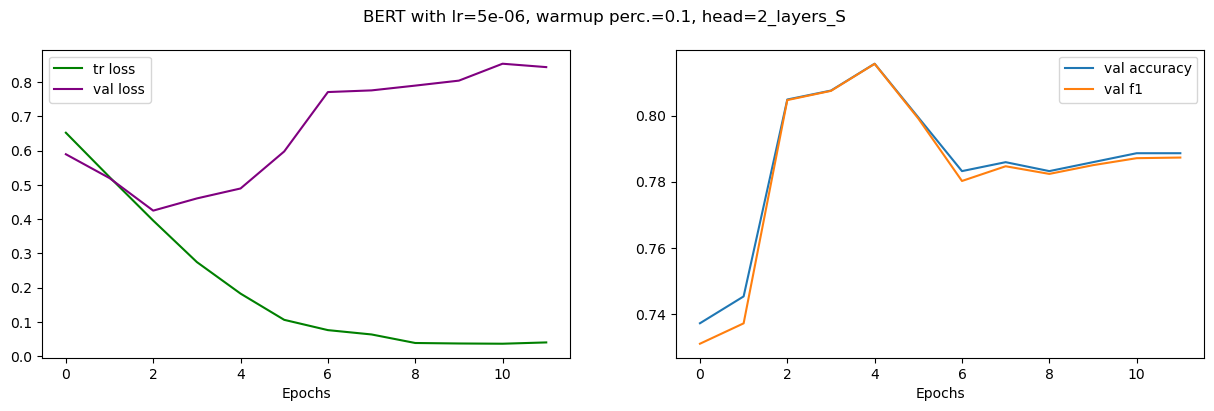

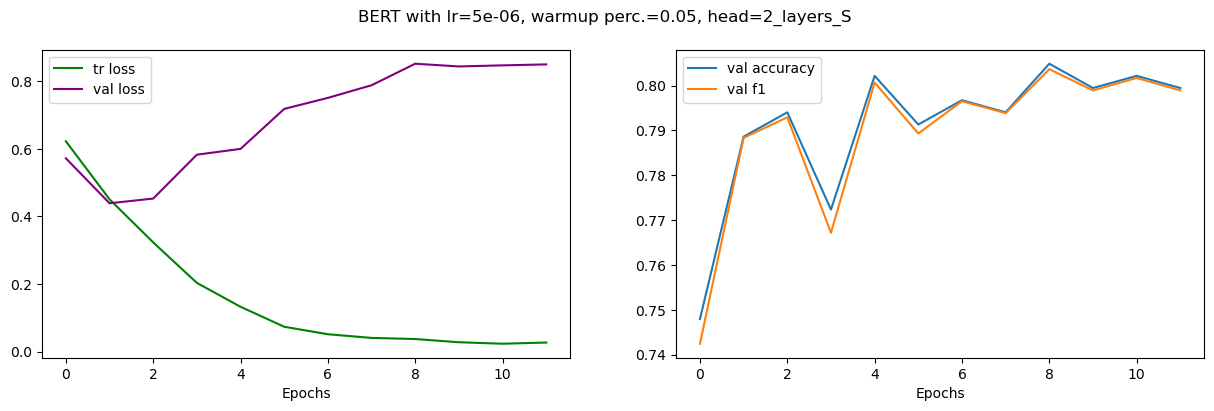

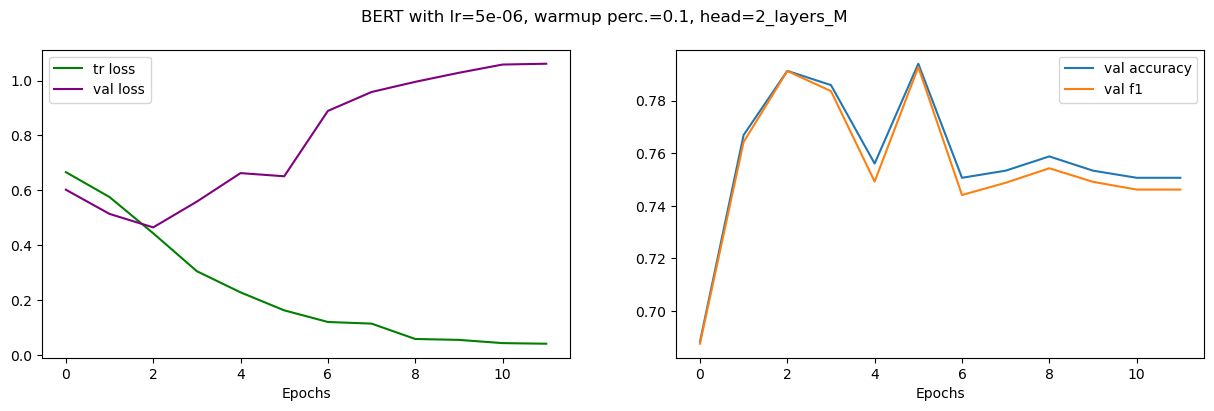

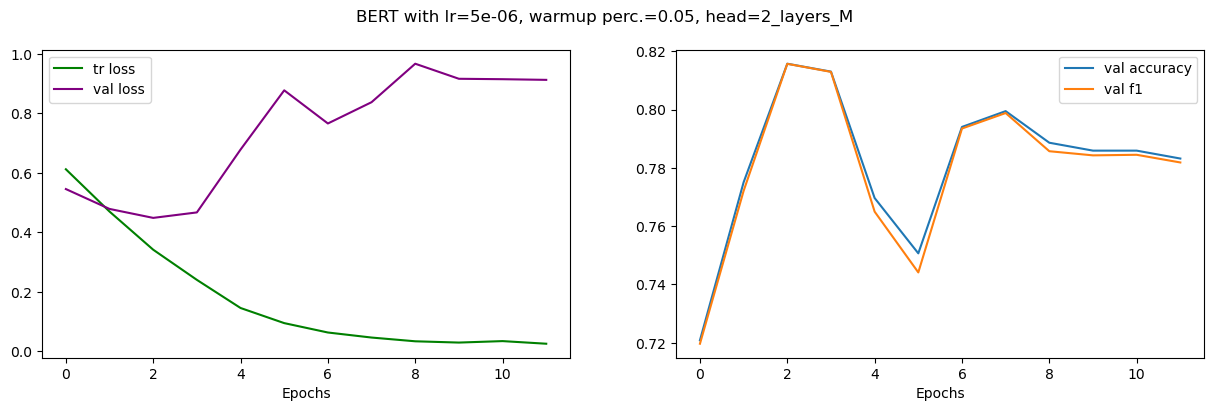

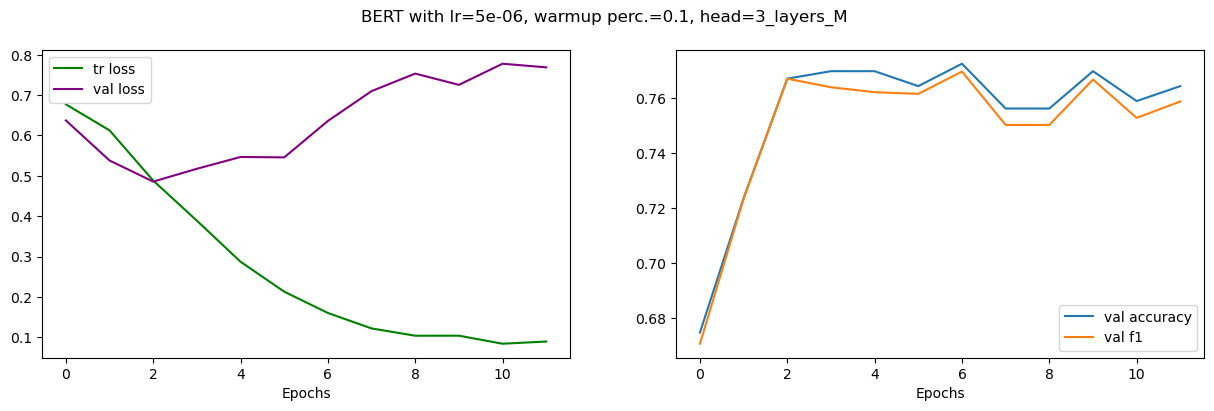

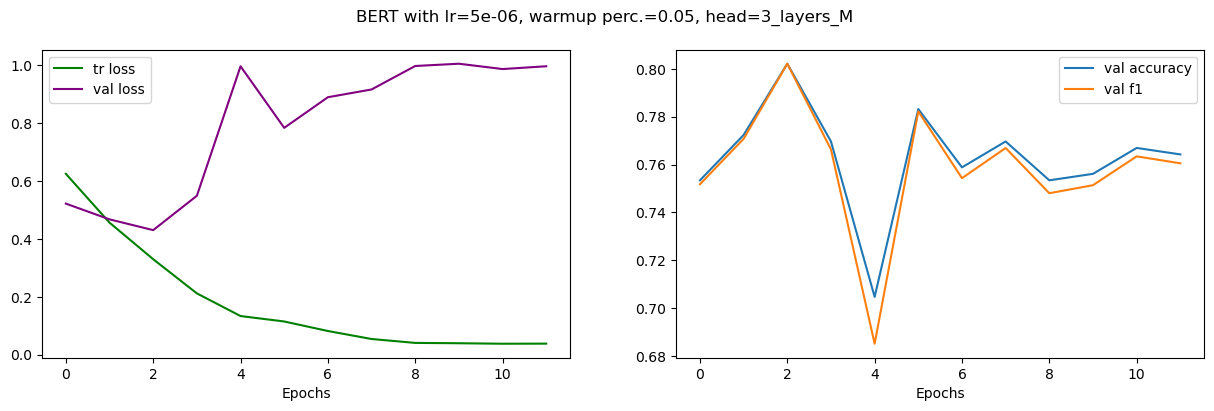

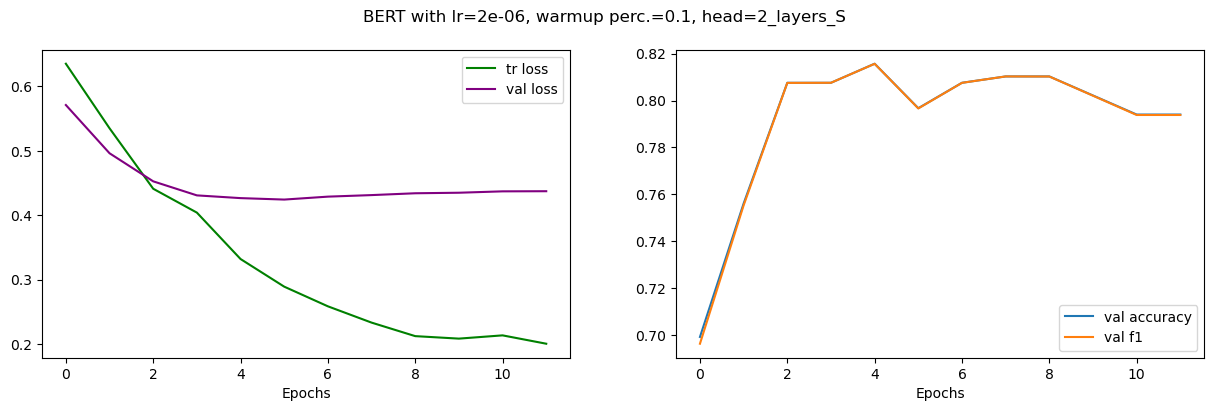

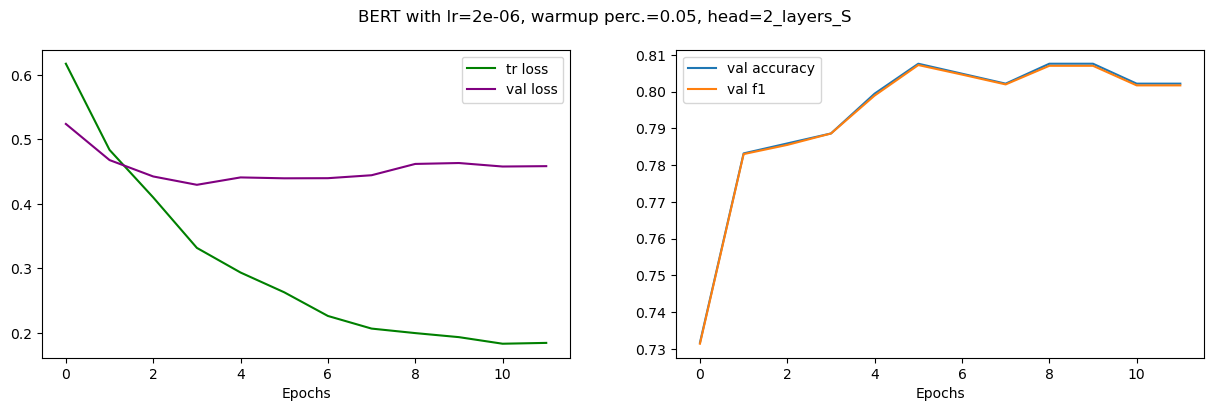

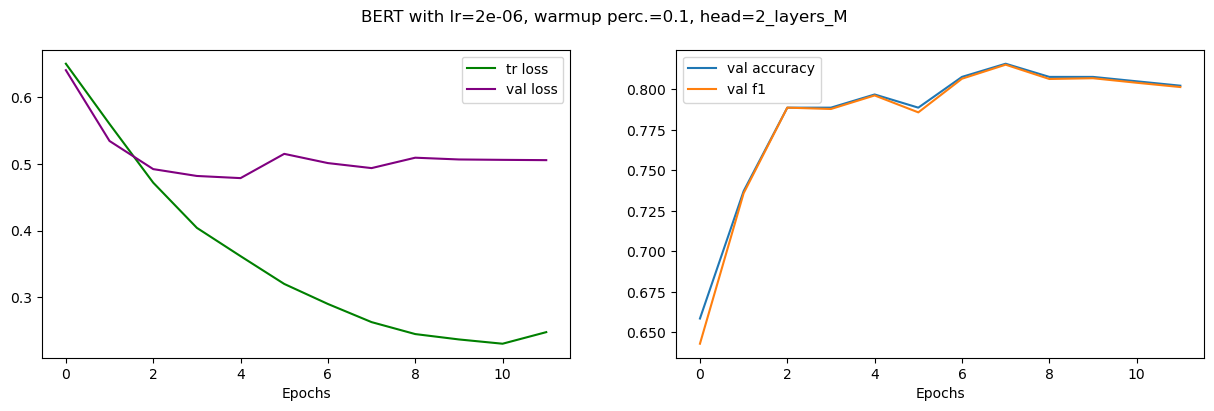

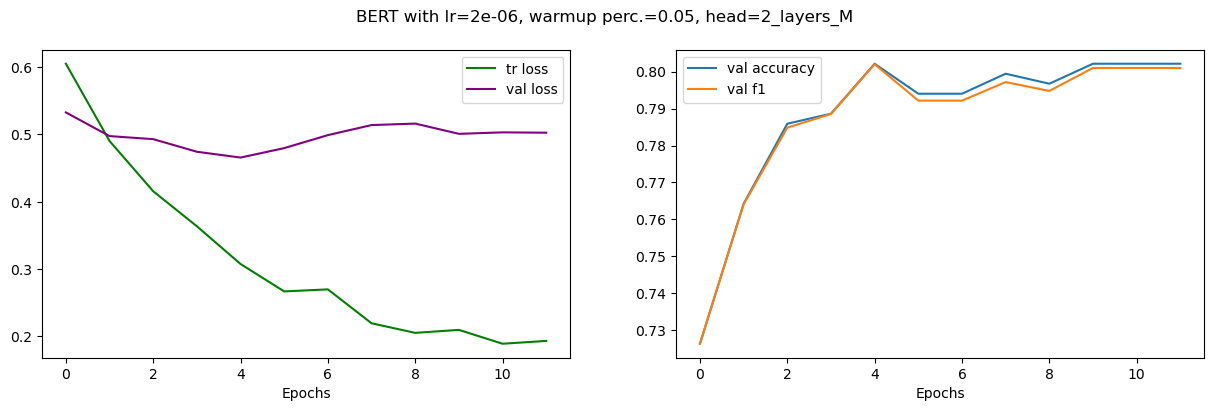

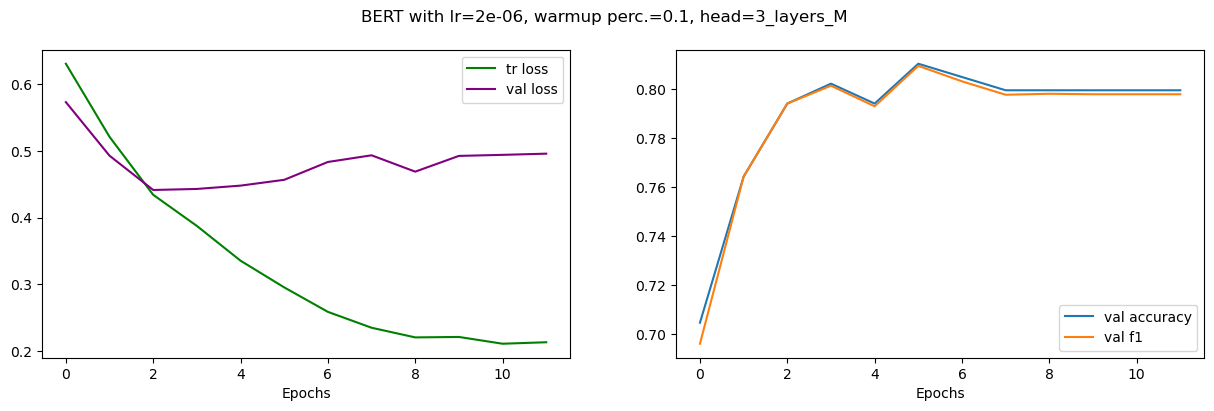

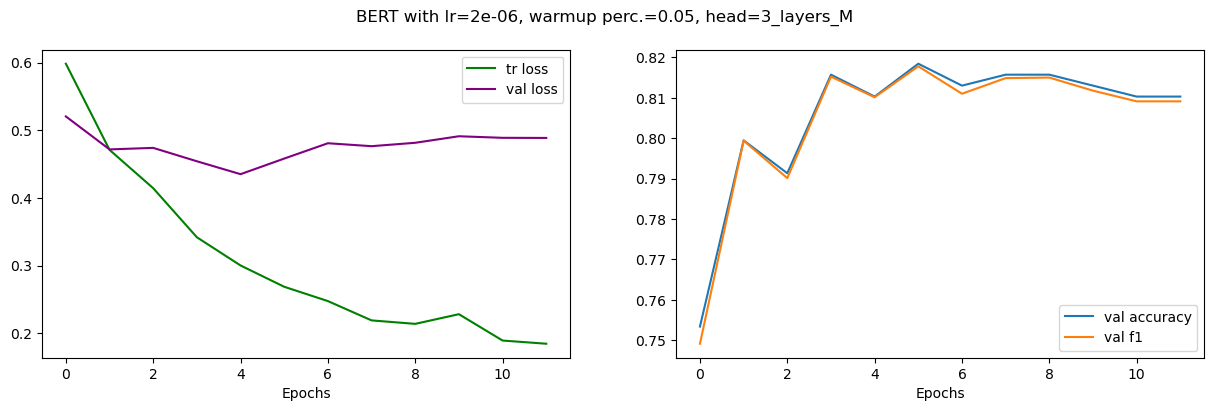

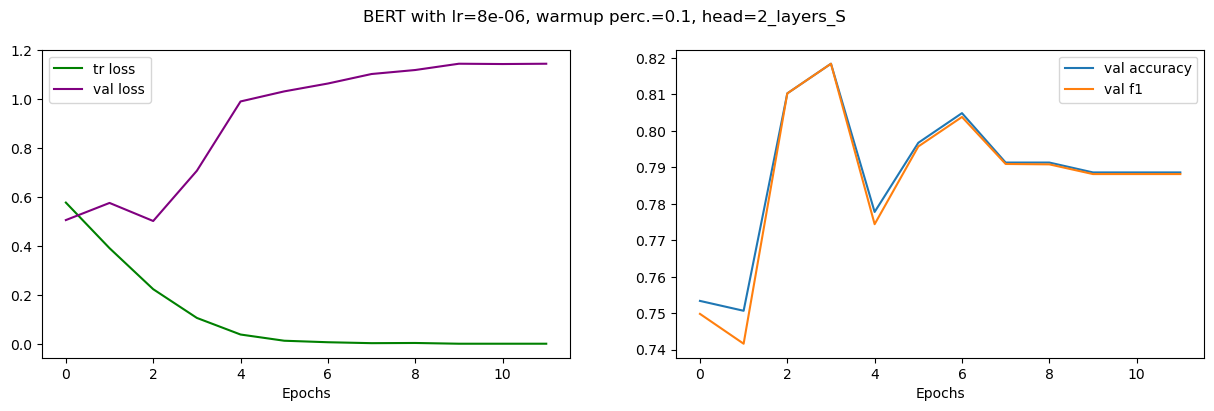

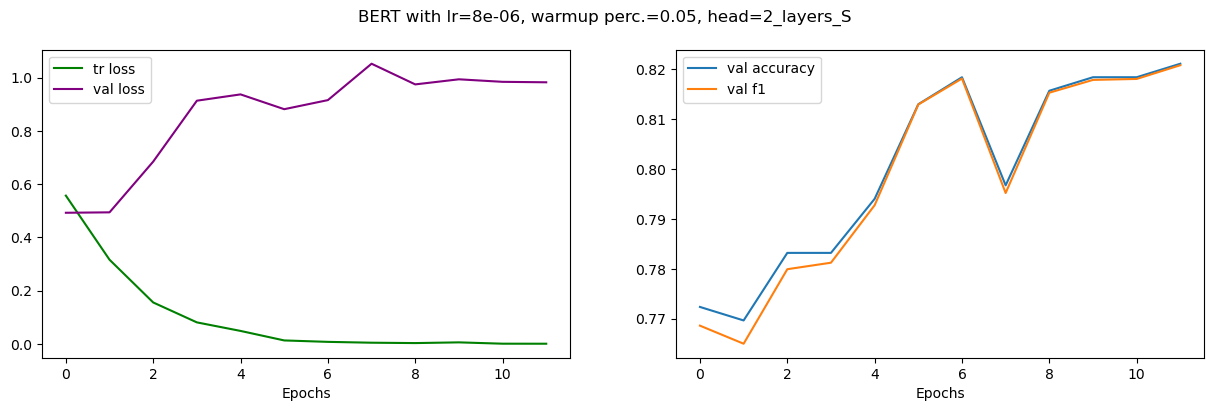

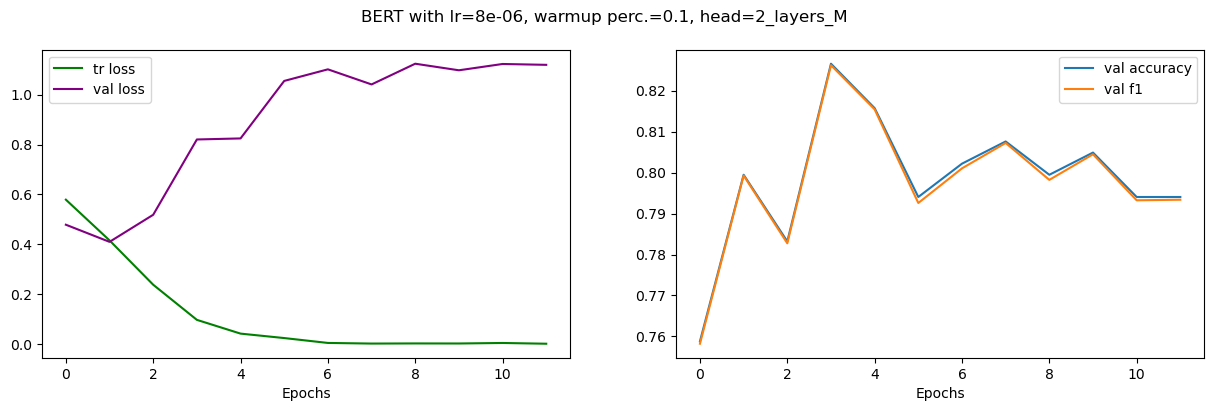

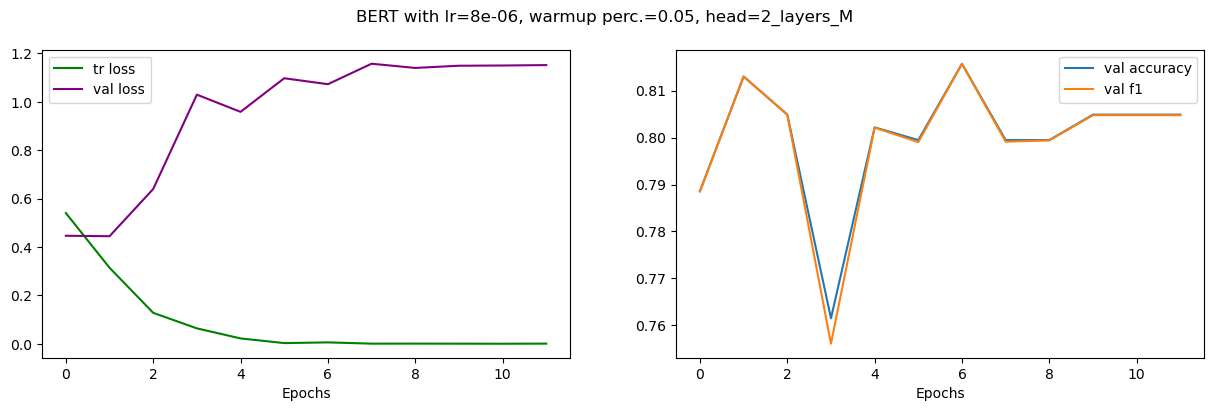

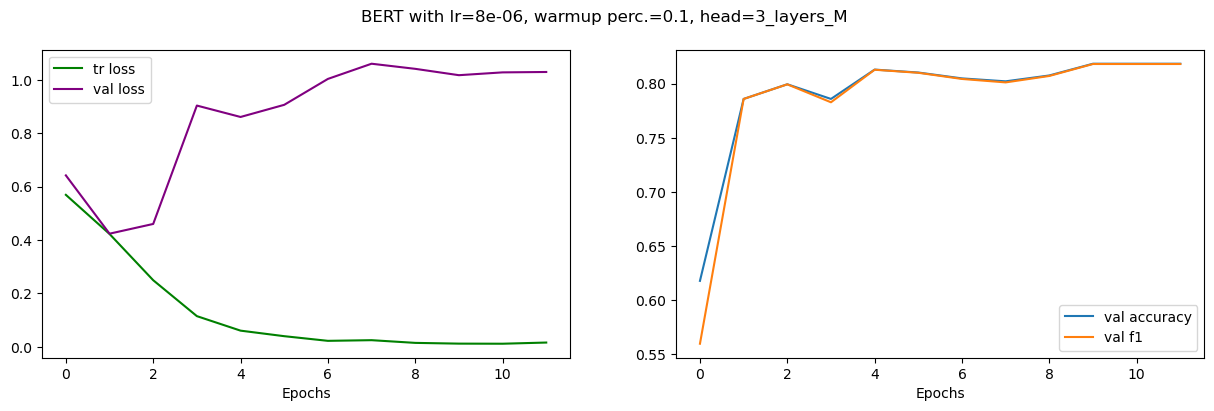

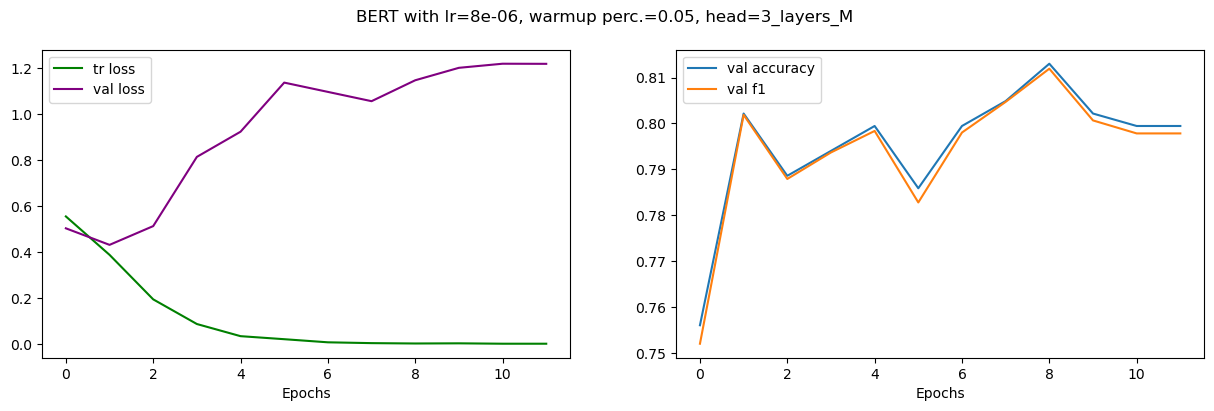

In [34]:
save_folder_pth = './bert_subtaskA/9_4_9-12.3' # Grid search run to analyze TO CHANGE


best_f1_list = []

for lr in lr_list:
    for clf_head_tuple in clf_head_list:
        for warmup_perc in warmup_perc_list:
            
            # Model path subfolder
            model_folder_str = 'lr{}_warmup{}_head_{}'.format(lr, warmup_perc, clf_head_tuple[1])
            model_folder_pth = os.path.join(save_folder_pth, model_folder_str)

            title = 'BERT with lr={}, warmup perc.={}, head={}'.format(lr, warmup_perc, clf_head_tuple[1])

            # Load model checkpoint for each epoch
            val_loss_list, tr_loss_list, val_f1_list, val_acc_list = [], [], [], []

            for epoch_i in range(max_epochs):
                model_pth = os.path.join(model_folder_pth,'bert_clf_{}.pt'.format(epoch_i))
                checkpoint = torch.load(model_pth)
                val_loss_list.append(checkpoint['val_loss'])
                tr_loss_list.append(checkpoint['tr_loss'])
                val_f1_list.append(checkpoint['val_f1'])
                val_acc_list.append(checkpoint['val_acc'])


            best_f1 = max(val_f1_list)
            best_epoch = val_f1_list.index(best_f1)
            best_f1_list.append((title, best_epoch, best_f1))


            plt.figure(figsize=(15,4))

            plt.subplot(1, 2, 1)
            plt.plot(tr_loss_list, label='tr loss', color='green')
            plt.plot(val_loss_list, label='val loss', color='purple')
            plt.xlabel('Epochs')
            plt.legend()

            plt.subplot(1,2,2)
            plt.plot(val_acc_list, label='val accuracy')
            plt.plot(val_f1_list, label='val f1')
            plt.xlabel('Epochs')
            plt.legend()

            plt.suptitle(title)
            plt.show()



In [38]:
for title, epoch, f1 in best_f1_list:
    print('{} at epoch {}, F1: {:.4f}'.format(title, epoch, f1))

BERT with lr=5e-06, warmup perc.=0.1, head=2_layers_S at epoch 4, F1: 0.8157
BERT with lr=5e-06, warmup perc.=0.05, head=2_layers_S at epoch 8, F1: 0.8037
BERT with lr=5e-06, warmup perc.=0.1, head=2_layers_M at epoch 5, F1: 0.7928
BERT with lr=5e-06, warmup perc.=0.05, head=2_layers_M at epoch 2, F1: 0.8157
BERT with lr=5e-06, warmup perc.=0.1, head=3_layers_M at epoch 6, F1: 0.7695
BERT with lr=5e-06, warmup perc.=0.05, head=3_layers_M at epoch 2, F1: 0.8022
BERT with lr=2e-06, warmup perc.=0.1, head=2_layers_S at epoch 4, F1: 0.8157
BERT with lr=2e-06, warmup perc.=0.05, head=2_layers_S at epoch 5, F1: 0.8072
BERT with lr=2e-06, warmup perc.=0.1, head=2_layers_M at epoch 7, F1: 0.8151
BERT with lr=2e-06, warmup perc.=0.05, head=2_layers_M at epoch 4, F1: 0.8020
BERT with lr=2e-06, warmup perc.=0.1, head=3_layers_M at epoch 5, F1: 0.8094
BERT with lr=2e-06, warmup perc.=0.05, head=3_layers_M at epoch 5, F1: 0.8178
BERT with lr=8e-06, warmup perc.=0.1, head=2_layers_S at epoch 3, F1: 